## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


### Checking data content and inbalance

In [3]:
train_data.shape

(84534, 10)

In [4]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [5]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [6]:
customer_treat = train_data[train_data.Promotion == 'Yes'].Promotion.count()
purchase_treat = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
purchase_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
customer_control = train_data[train_data.Promotion == 'No'].Promotion.count()

In [7]:
train_data[['Promotion', 'purchase']].groupby('Promotion').sum()


,purchase
Promotion,
No,319
Yes,721


<AxesSubplot: xlabel='Promotion', ylabel='count'>

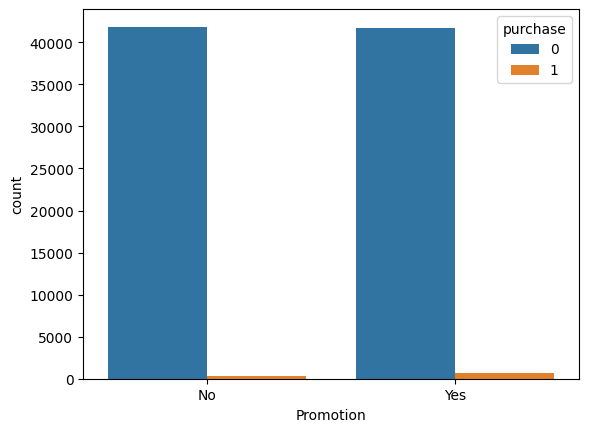

In [8]:
sb.countplot(data = train_data, x = 'Promotion', hue = 'purchase')

### Analyze of invariant metrics

Here I'll figure out and analyze our invariant metric of participants in each group (who received the promotional offer and who doesn't)

$$ H0 : Experimental_{group} - Control_{group} = 0 $$
$$ H1 : Experimental_{group} - Control_{group} > 0 $$
$$ \alpha = 0.05 $$

In [9]:
print(f"The number who received the promotion: {customer_treat} and the number who did not: {customer_control}.")


The number who received the promotion: 42364 and the number who did not: 42170.


In [10]:
# Calculating a measurable statistic in the difference of our group sizes
Promotion_avg = ((train_data.Promotion == "Yes").sum())/train_data.shape[0]
Non_Promotion_avg = (train_data.Promotion == "No").sum()/train_data.shape[0]
sample_difference = Promotion_avg - Non_Promotion_avg
sample_difference

0.00229493458253488

In [11]:
# Bootstraping our differences to get a model of the distribution for our null
differences = []
for _ in range(10000):
    bootsamp = train_data.sample(30000, replace=True)
    Promotion_avg = ((bootsamp.Promotion == "Yes").sum())/bootsamp.shape[0]
    Non_Promotion_avg = (bootsamp.Promotion == "No").sum()/bootsamp.shape[0]
    differences.append(Promotion_avg - Non_Promotion_avg)

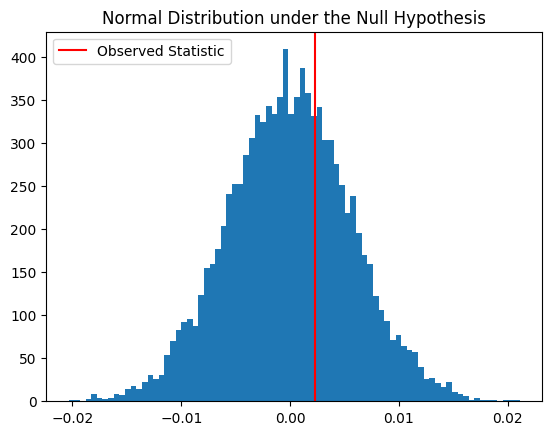

In [12]:
# distribution of our null hypothesis
null_vals = np.random.normal(0, np.std(differences), 10000)
plt.hist(null_vals, bins=80)
plt.axvline(sample_difference, color='r', label ="Observed Statistic")
plt.legend(loc='upper left')
plt.title("Normal Distribution under the Null Hypothesis");

In [13]:
# Determining the signifigance of our result 
p_val = (sample_difference>null_vals).mean()
p_val

0.6614

### Analyzing the NIR

$$ H0 : NetIncrementRevenue = 0 $$
$$ H1 : NetIncrementRevenue > 0 $$
Bonferroni correction applied: 
$$ \alpha = 0.025 $$

In [14]:
customer_treat = train_data[train_data.Promotion == 'Yes'].Promotion.count()
purchase_treat = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
purchase_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
NIR = (10 * purchase_treat - 0.15 * customer_treat) - 10 * purchase_control
NIR

-2334.5999999999995

In [15]:
NIR = (10 * purchase_treat - 0.15 * customer_treat) - 10 * purchase_control
NIR

-2334.5999999999995

In [16]:
# Bootstraping the NIR to visualize the distribution for Null and see the observed statistics 
NIRs = []
for _ in range(10000):
    bootsample = train_data.sample(30000, replace=True)
    purchase_treatment = bootsample[bootsample['Promotion'] == "Yes"].purchase.sum()
    customer_treatment = bootsample[bootsample['Promotion'] == "Yes"].shape[0]
    purchase_control = bootsample[bootsample['Promotion'] == "No"].purchase.sum()
    NIRs.append((10*purchase_treatment - 0.15*customer_treatment)-10*purchase_control)

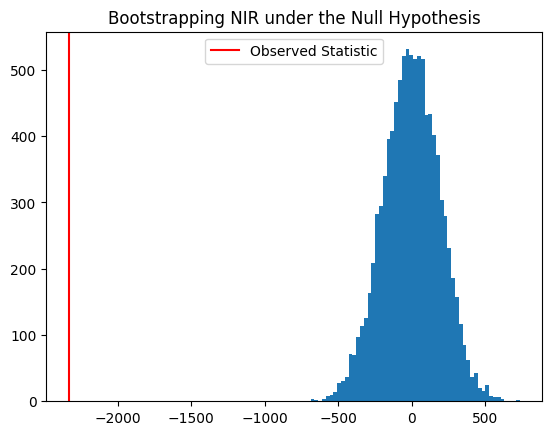

In [17]:
# Plotting under the null 
plt.axvline(NIR, color='r', label ="Observed Statistic")
null_NIRs = np.random.normal(0, np.std(NIRs), 10000)
plt.hist(null_NIRs, bins=60)
plt.title("Bootstrapping NIR under the Null Hypothesis")
plt.legend();

In [18]:
# Checking the signifigane is 0
pval = (NIR>null_NIRs).mean()
pval

0.0

### Analyzing the IRR

$$ H0 : IncrementalResponseRate = 0 $$
$$ H1 : IncrementalResponseRate > 0 $$
Bonferroni correction applied: 
$$ \alpha = 0.025 $$

In [19]:
customer_treat = train_data[train_data.Promotion == 'Yes'].Promotion.count()
purchase_treat = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
purchase_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
customer_control = train_data[train_data.Promotion == 'No'].Promotion.count()
IRR = (purchase_treat/customer_treat) - (purchase_control/customer_control)
IRR

0.009454547819772702

In [20]:
# Bootstraping the IRR to visualize the distribution for Null and see the observed statistics 
IRRs = []
for _ in range(10000):
    bootsample2 = train_data.sample(30000, replace=True)
    purchase_treatment = bootsample2[bootsample2['Promotion'] == "Yes"].purchase.sum()
    customer_treatment = bootsample2[bootsample2['Promotion'] == "Yes"].shape[0]
    purchase_control = bootsample2[bootsample2['Promotion'] == "No"].purchase.sum()
    customer_control = bootsample2[bootsample2['Promotion'] == "No"].shape[0]
    IRR_boot = purchase_treatment/customer_treatment - purchase_control/customer_control
    IRRs.append(IRR_boot)

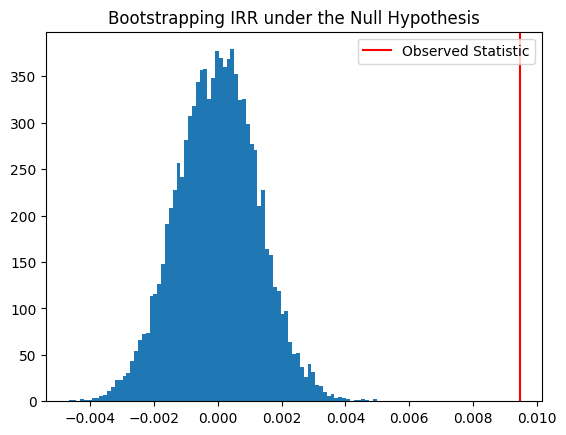

In [21]:
# Reviewing our observed statistic against the bootstrapped sample
plt.axvline(IRR, color='r', label ="Observed Statistic")
null_IRRs = np.random.normal(0, np.std(IRRs), 10000)
plt.hist(null_IRRs, bins=80)
plt.title("Bootstrapping IRR under the Null Hypothesis")
plt.legend();

In [22]:
# Calculating the signifigance of this result 
pval_IRR = (IRR>null_IRRs).mean()
pval_IRR

1.0

## Conclusions
$ About-NIR $:

As we can observed on the cells above, the NIR have an P value near to 0 fare away below our confidence interval, and for that we fail in reject the null hypothesis. Therefore with this campaign model we are actually REDUCING the NIR, making the company wast money without selecting the best's customers that should receive the promotional cupom, and the objective of this campaign it's to optimize this index.

$ About-IRR $:

Here we acctually can see an interesting statistical increasing on IRR comparing the control and experimental group, with an P value near of 1, we can clearly reject the null hypothesis. So therefore we can see that our campaign had an positive effect under the customers who purchased the product with the promotional offer as compared with those who didn't received the promotion.

# Features Correlations

Visualizing and understanding features

C:\Users\zanin\AppData\Local\Temp\ipykernel_18708\1647413240.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


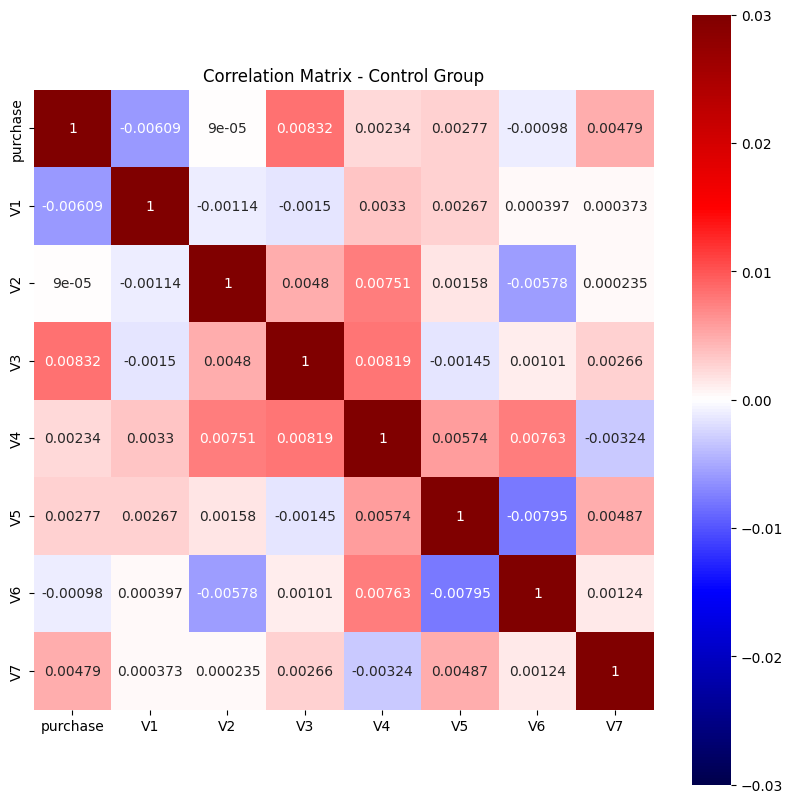

In [23]:
# filtering data for control group:
control = train_data[train_data.Promotion == 'No']
sel_features = ['purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

# evaluating features' correlation for experimental group:
contr_corr = control[sel_features].corr()

# creating correlation plot:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

sb.heatmap(contr_corr, annot = True, fmt = '.3g', vmin = -.03, vmax = .03, center = 0, 
                        cmap = 'seismic', square = True)
ax.set_title('Correlation Matrix - Control Group')

fig.show()

C:\Users\zanin\AppData\Local\Temp\ipykernel_18708\88797020.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


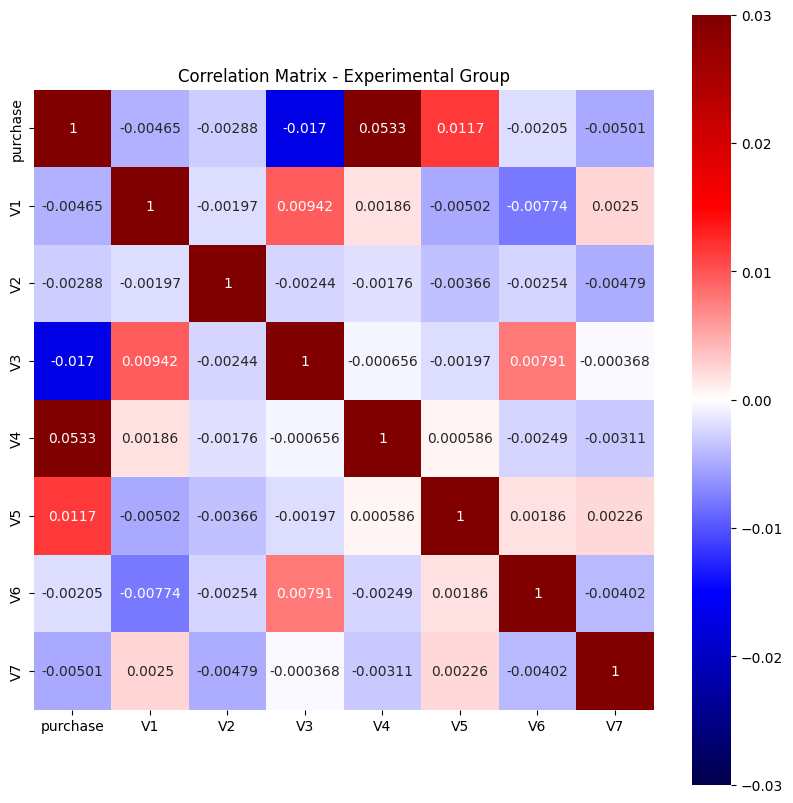

In [24]:
# filtering data for experimental group:
experimental = train_data[train_data.Promotion == 'Yes']

# evaluating features' correlation for experimental group:
exper_corr = experimental[sel_features].corr()

# creating correlation plot:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

sb.heatmap(exper_corr, annot = True, fmt = '.3g', vmin = -.03, vmax = .03, center = 0, 
                        cmap = 'seismic', square = True)
ax.set_title('Correlation Matrix - Experimental Group')

fig.show()

In [25]:
# observing the percentage variation in the correlation between control and experimental group: 
purch_corr = pd.DataFrame()
purch_corr['control'] = contr_corr['purchase']
purch_corr['experimental'] = exper_corr['purchase']
purch_corr['percent_variation'] = -((purch_corr.control - purch_corr.experimental)/purch_corr.control)*100
purch_corr

,control,experimental,percent_variation
purchase,1.000000,1.000000,-0.000000
V1,-0.006088,-0.004651,-23.605724
V2,0.000090,-0.002885,-3306.003045
V3,0.008325,-0.017012,-304.357526
V4,0.002344,0.053348,2176.227435
V5,0.002771,0.011711,322.600958
V6,-0.000980,-0.002049,109.222660
V7,0.004786,-0.005005,-204.587034


### $Consideration on Correlation Analysis$

It's interesting to observe that, considering the only difference between control and experimental groups is whether or not they were given a promotion ticket, among the features with higher correlation, the one that was most responsive to the experiment is represented by V4.

V4 already had a positive correlation with the purchase feature, considering the control group. With the promotion event, its positive correlation increased by over 2000%, which is impressive. Considering the ideal experiment, where all the other variables are controlled, we could say that the higher V4 is, the more susceptible the client is to use the promotion and purchase the product. Since V4 is a binary feature (1 or 2), we can translate it as class 2 being more receptive to the promotion event.

V5 behaves the same as V4, but with lower intensity. In the control group, it already showed a positive correlation with the purchase, and this correlation was powered with the promotion, increasing by over 300%. V5 represents categories from 1 to 4, indicating that categories represented by higher numbers tend to be more affected by the promotion, in a positive way.

A different response is shown when observing the V3 feature. In the control group, this variable represented the highest positive correlation, while in the experimental group this tendency was reversed: it became the second-highest correlation score, and this time in a negative direction. It looks like clients related to higher values of V3 have a naturally higher propensity for purchasing the product. At the same time, these clients are not quite receptive to promotional events.

Other features like V2 show a great variation when comparing control and experimental groups. However, they don't stand out because their correlation values are too low in comparison to the other features.

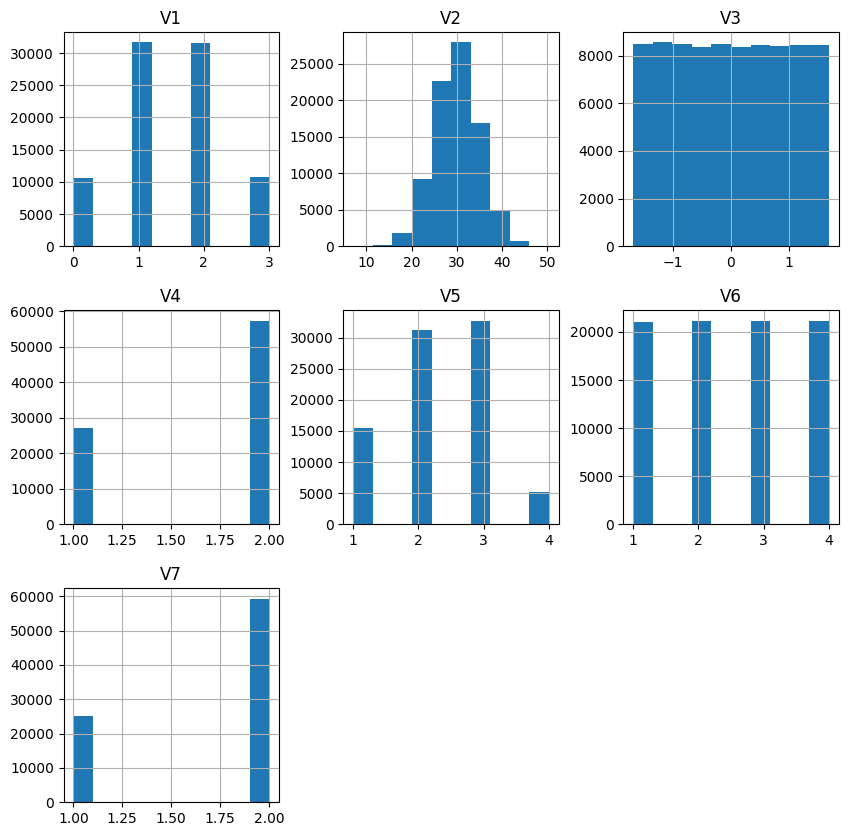

In [26]:
# Ploting histograms of features V1 -V7
data_features = train_data.drop(['ID', 'Promotion', 'purchase'], axis = 1)
data_features.hist(figsize = (10, 10))
plt.show()

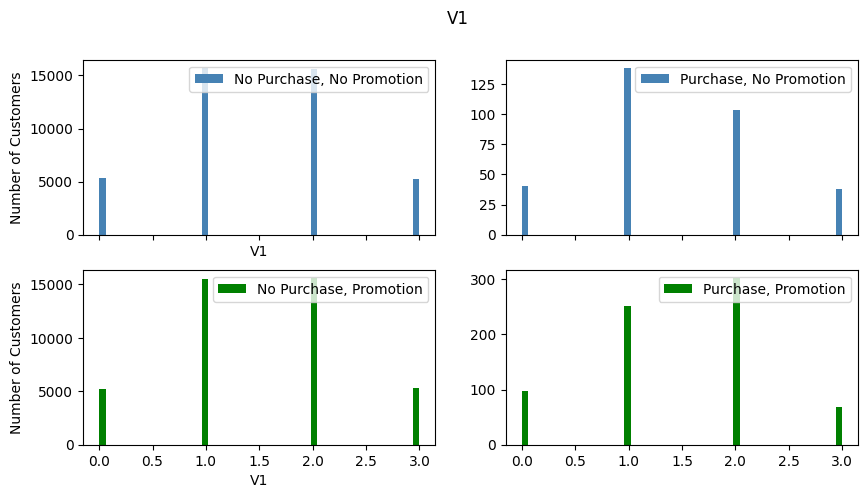

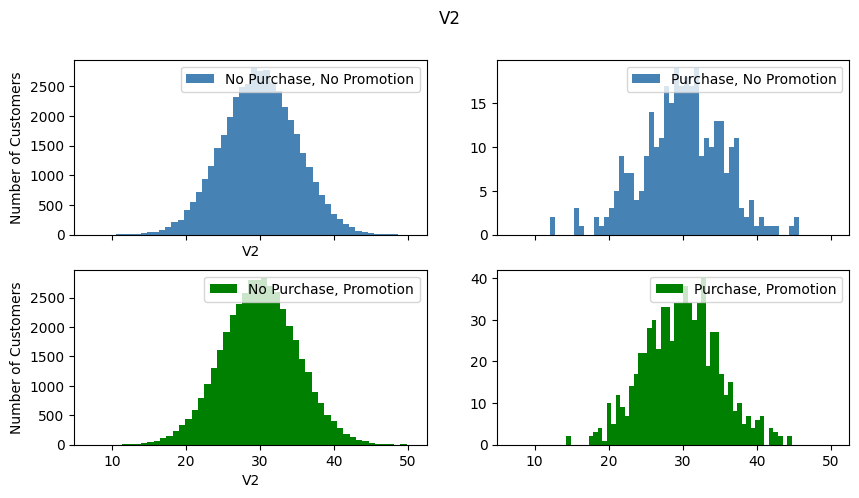

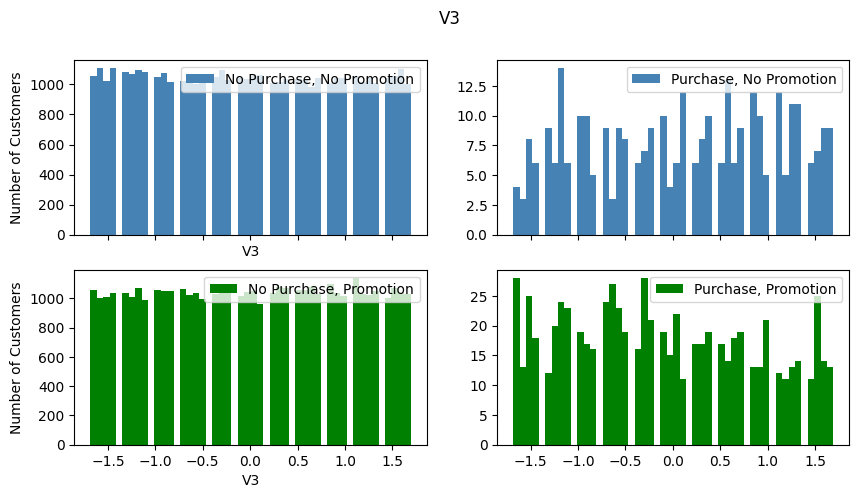

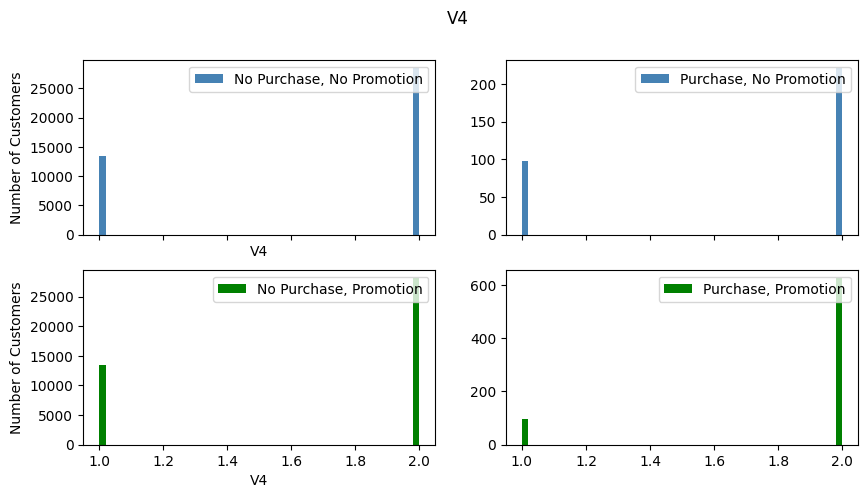

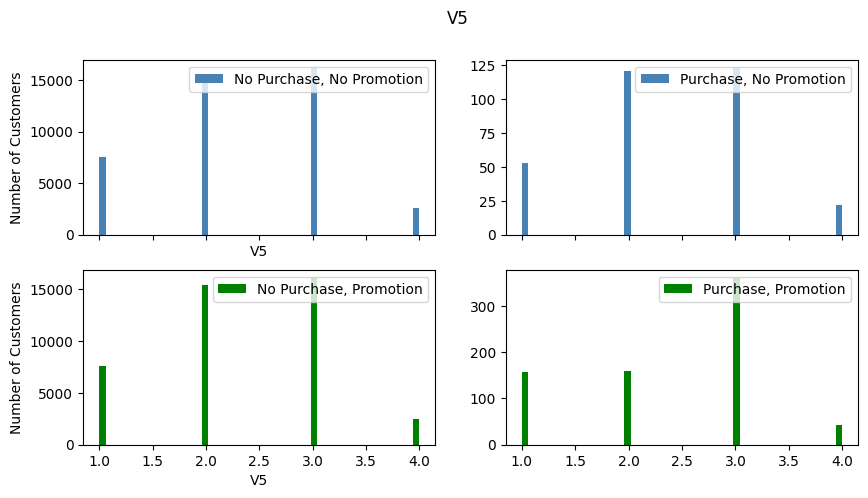

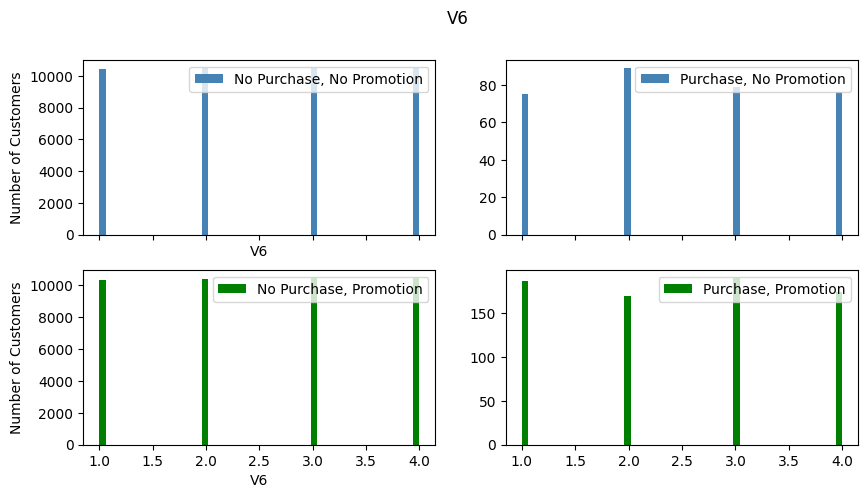

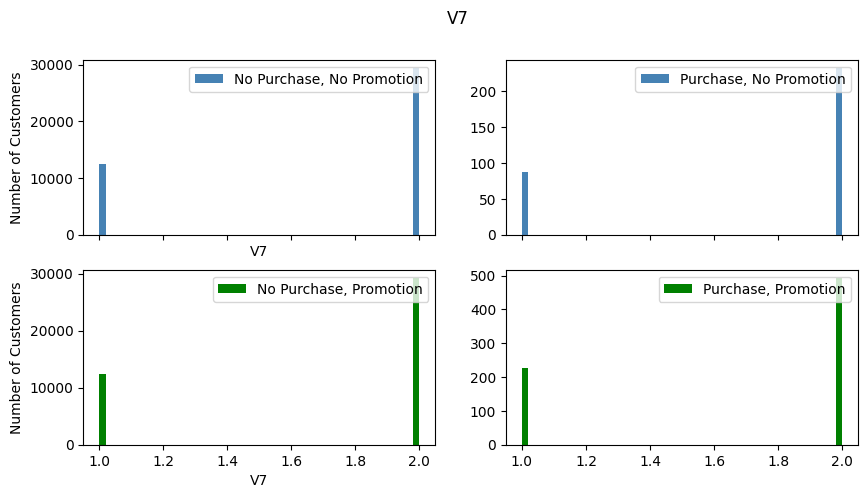

In [27]:
# plot histograms of features V1-V7 in all 4 subgroups of purchase x Promotion
for feature in data_features.columns:

    # filter on non-purchasers without promotion
    df_no_purch_without_prom = train_data[feature][(train_data['purchase']==0) & (train_data['Promotion']=='No')]
    # filter on purchasers without promotion
    df_purch_without_prom = train_data[feature][(train_data['purchase']==1) & (train_data['Promotion']=='No')]
    # filter on non-purchasers with promotion
    df_no_purch_with_prom = train_data[feature][(train_data['purchase']==0) & (train_data['Promotion']=='Yes')]
    # filter on purchasers with promotion
    df_purch_with_prom = train_data[feature][(train_data['purchase']==1) & (train_data['Promotion']=='Yes')]

    fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True)
    fig.suptitle(feature)

    ax[0,0].hist(df_no_purch_without_prom, histtype='barstacked', bins=50, color='steelblue', label='No Purchase, No Promotion')
    ax[0,1].hist(df_purch_without_prom, histtype='barstacked', bins=50, color='steelblue', label='Purchase, No Promotion')
    ax[1,0].hist(df_no_purch_with_prom, histtype='barstacked', bins=50, color='green', label='No Purchase, Promotion')
    ax[1,1].hist(df_purch_with_prom, histtype='barstacked', bins=50, color='green', label='Purchase, Promotion')
    ax[0,0].set_ylabel('Number of Customers')
    ax[1,0].set_ylabel('Number of Customers')
    ax[0,0].set_xlabel(feature)
    ax[1,0].set_xlabel(feature)

    ax[0,0].legend(loc='upper right')
    ax[0,1].legend(loc='upper right')
    ax[1,0].legend(loc='upper right')
    ax[1,1].legend(loc='upper right')

    plt.show()

### $Considerations on Histogram Analysis$

In the experimental group we can see some interesting changes. In V1, for example, the trend presented by class 1 in the control group is reverted, since proportionally class 2 increases its participation with the promotion, and class 1 decreases the participation among the buyers.

V2 shows that clients with values closer to the mean are more responsive to the promotion.

Again, we can see through V3 that its distribution resembles a mirrored-image of the control group, considering the ones who purchased the product. In other words, lower values of V3 represent consumers that purchase the product because of the promotion, while higher values of V3 represent consumers that are discouraged to buy the product because of the promotion.

Class 1 in V4 tends to be not responsive to the promotional event, as well as class 2 in V6 and more significantly in the V5 feature. In the other hand, class 3 in V5 seems to increase its purchase rate with the promotional event.

# Creating models

Trying RandomForestClassifier

In [28]:
# Reviewing the number of individuals who purchased products in both the control and experiment condition 
train_data.groupby('Promotion').purchase.sum()

Promotion
No     319
Yes    721
Name: purchase, dtype: int64

In [29]:
# Copying the dataframe over 
data_exp = train_data.copy()

In [30]:
# only considering the experiment group for our model training 
data_exp = data_exp[data_exp['Promotion']=="Yes"]

In [31]:
# Dropping the irrelavant columns 
data_exp.drop(['ID','Promotion'], axis = 1, inplace=True)

In [32]:
# Checking the shape is correct
data_exp.shape

(42364, 8)

In [33]:
# Viewing our data again 
data_exp.head()

,purchase,V1,V2,V3,V4,V5,V6,V7
4,0,3,28.044331,-0.385883,1,1,2,2
8,0,2,31.930423,0.393317,2,3,1,2
10,0,1,32.770916,-1.511395,2,1,4,1
12,0,1,36.957009,0.133583,2,3,1,1
14,0,3,36.911714,-0.905350,2,2,4,1


In [34]:
# Splitting our data into predictors and target variables
X = data_exp.drop(['purchase'],axis=1)
y = data_exp.purchase

In [35]:
# Scaling our inputs 
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [36]:
# Instantiating our model and fitting it
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X,y)

RandomForestClassifier()

In [37]:
# Loading in our test data 
test_data = pd.read_csv('./test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [38]:
# Tailoring the test data to test our model 
data_exp_test = train_data.copy()
data_exp_test = data_exp_test[data_exp_test['Promotion']=="Yes"]
data_exp_test.drop(['ID','Promotion'], axis = 1, inplace=True)
X_test = data_exp_test.drop(['purchase'],axis=1)
y_test = data_exp_test.purchase

In [39]:
# Scaling our test input 
X_test = min_max_scaler.fit_transform(X_test)

In [40]:
# Predicting our target values
y_pred = clf.predict(X_test)

In [41]:
# Checking our accuracy for the model 
accuracy = (y_pred == y_test).mean()
print("Our accuracy for the random forest model was {0:.5f}%".format(accuracy))

Our accuracy for the random forest model was 0.99995%


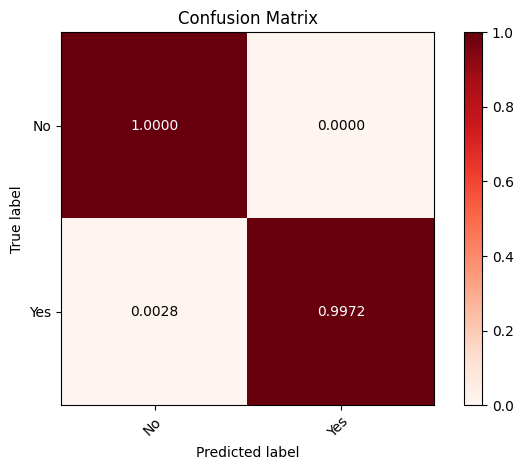

In [42]:
### Creating a confusion matrix visual

confusion_matrix = confusion_matrix(y_test, y_pred)
classes = ['No','Yes']
confusion_matrix  = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Reds)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(confusion_matrix.shape[1]),
        yticks=np.arange(confusion_matrix.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title="Confusion Matrix",
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

fmt = '.4f'
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], fmt),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")
fig.tight_layout()
ax;

In [43]:
# Converting our numeric outputs to Yes/No's 
promotion_yes_no = []
for value in y_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
    

In [44]:
# Converting to a NumPy Array 
np.asarray(promotion_yes_no)

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [45]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''        
    df = min_max_scaler.fit_transform(df)
    
    y_pred = clf.predict(df)
    
    promotion_yes_no = []
    for value in y_pred:
        if value == 0:
            promotion_yes_no.append("No")
        if value == 1:
            promotion_yes_no.append("Yes")
            
    promotion = np.asarray(promotion_yes_no)
    
    
    
    
    return promotion

In [46]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0526.

Your nir with this strategy is 7.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.05263157894736842, 7.15)

So, we managed to get a better IRR but a signifigantly worse nir than the experts over at Udacity... Regardless, we still managed a signifigantly better approach than what we had observed with the experiment.

Our confusion matrix indidcated that our accuracy is only hindered by a small number of false negatives. Prehaps if we had a less conservative model we may see a higher NIR rate. Allowing for a higher number of false positives may actually improve our NIR metric at the cost of our IRR. let's keep improving


In [47]:
promotion_group = train_data[train_data['Promotion']=='Yes']

In [48]:
# under-sampling due to imbalanced labels 
print('Prior under-sampling:\n' + str(promotion_group['purchase'].value_counts()) + '\n')
count_0, count_1 = promotion_group['purchase'].value_counts()

# divide by class
df_0 = promotion_group[promotion_group['purchase']==0]
df_1 = promotion_group[promotion_group['purchase']==1]

df_0_under = df_0.sample(count_1, random_state=42)
df_under = pd.concat([df_0_under, df_1], axis=0)

print('Post under-sampling:\n' + str(df_under['purchase'].value_counts()))

Prior under-sampling:
0    41643
1      721
Name: purchase, dtype: int64

Post under-sampling:
0    721
1    721
Name: purchase, dtype: int64


In [49]:
# prepare train and test dataset
X = df_under.drop(['ID','Promotion','purchase'], axis=1)
y = df_under['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# initialize classifier
clf_2 = RandomForestClassifier(random_state=42)

# fit classifier
model = clf_2.fit(X_train, y_train)

# evaluate classifier
accuracy = model.score(X_test,y_test)
print('Accuracy = ' + str("{:.2f}".format(accuracy*100)) + '%')

Accuracy = 57.14%


In [50]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = pd.Series(model.predict(df)).map({0:'No', 1:'Yes'}).values
    
    return promotion

# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0162.

Your nir with this strategy is 104.55.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.016218458401275407, 104.54999999999995)

#### $RandomForestClassifier Model Conclusion$ 
Undersampling already bring improvement (104.55) on NIR but still under the model of Udacity, and a little decrease (0.162) on the IRR, lets try with another algorithm 

## Promotion Strategy and Model Optimization 

Let's try another algorithm, this time with AdaBoostClassifier

In [51]:
# prepare train and test dataset
X = df_under.drop(['ID','Promotion','purchase'], axis=1)
y = df_under['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# initialize classifier
clf_3 = AdaBoostClassifier(random_state=42)

# fit classifier
model2 = clf_3.fit(X_train, y_train)

# evaluate classifier
accuracy = model2.score(X_test,y_test)
print('Accuracy = ' + str("{:.2f}".format(accuracy*100)) + '%')

Accuracy = 60.71%


In [52]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = pd.Series(model2.predict(df)).map({0:'No', 1:'Yes'}).values
    
    return promotion

# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0176.

Your nir with this strategy is 256.55.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01760268954998508, 256.54999999999995)

Woow here we can see and incredible evolution of NIR metric, outing of 187.45 to 256.55 with our Adaboostclassifier even without using gridsearchcv. let's see if we are able to improve a little bit more with Gridsearch

In [53]:
clf_3.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [54]:
clf_3.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [55]:
parameters = {
    'learning_rate': [0.1, 0.3, 1.0],
    'n_estimators': [50,100],
}

clf_3_CV = GridSearchCV(clf_3, param_grid = parameters, cv= 10 )

In [56]:
%%time

model3 = clf_3_CV.fit(X_train, y_train)

CPU times: total: 3.41 s
Wall time: 6.42 s


In [57]:
# evaluate classifier
accuracy = model3.score(X_test,y_test)
print('Accuracy = ' + str("{:.2f}".format(accuracy*100)) + '%')

Accuracy = 61.76%


In [58]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = pd.Series(model3.predict(df)).map({0:'No', 1:'Yes'}).values
    
    return promotion

# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0182.

Your nir with this strategy is 322.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018202146690518783, 322.0)

# Conclusion

In this last approach we finally achieved restults that clearly overcome the results brought for Udacity, while we could mantained our IRR with a similar value (0.0182) our NIR now have an amazying increase of almost 70%!! this was really good to see.

Understand how differently these features behave when comparing our study groups made it possible to elaborate different feature enginnering strategies that resulted in better optimization. So this project was important to shows how important it is have a good analysis on Data science projects even when it's not clear what a feature represents, through the analysis process we were able to guess what some features are related with our business problem.
